## Machine Learning Project: Predicting Boston House Prices With Regression

In this project, we will develop and evaluate the performance and the predictive power of a model trained and tested on data collected from houses in Boston’s suburbs. Once train the model and get a good fit, we will use this model to predict the monetary value of a house located at the Boston’s area.

The dataset used in this project comes from the **UCI Machine Learning Repository**. This data was collected in 1978 and each of the 506 entries represents aggregate information about 14 features of homes from various suburbs located in Boston.

The features can be summarized as follows:

* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* INDUS: This is the proportion of non-retail business acres per town.
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per 10,000
* PTRATIO: This is the pupil-teacher ratio by town
* B: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population
* MEDV: This is the median value of owner-occupied homes in 1000's

For this project, the data has been preprocessed with following steps:

* The essential features for the project are: ‘RM’, ‘LSTAT’, ‘PTRATIO’ and ‘MEDV’. The remaining **unwanted features** have been excluded.
* 16 data points with a ‘MEDV’ value of 50.0 have been removed. As they likely contain **censored** or **missing values**.
* One data point with a ‘RM’ value of 8.78 it is considered an **outlier** and has been removed for the optimal performance of the model.
* As this data is out of date, the ‘MEDV’ value has been **scaled multiplicatively** to account for 35 years of markt inflation.

In [135]:
#importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# Import supplementary visualizations code visuals.py
import visuals as vs

# Load the Boston housing dataset
#names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('housing.csv')
prices = data['MEDV'] #target variable
features = data.drop('MEDV', axis = 1) 

# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


### Data Exploration

It is always a good practice to start with an exploratory analysis of the dataset and provide some observations.
Lets start by calculating some descriptive statistics of Boston Housing Prices

In [108]:
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [109]:
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


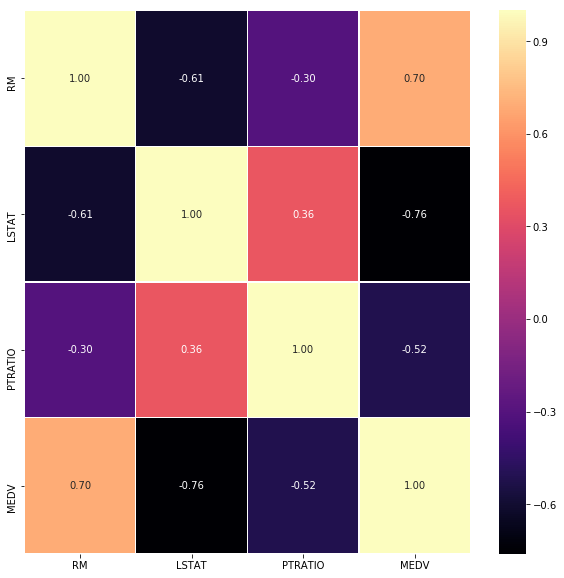

In [110]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

From Correlation data, We can confim that variable **LSTAT, RM and PTRATIO** have good corelation with our output variable MEDV. These variables we need to consider when we optimze our predictive value

### Feature Observation

It is very important to know which features are important for predicting our target variable. From the above correlation matrix we concluded that LSTAT, RM and PTRATIO are highly correlated to Prices. 

* 'RM' is the average number of rooms among homes in the neighborhood.
* 'LSTAT' is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
* 'PTRATIO' is the ratio of students to teachers in primary and secondary schools in the neighborhood.



* **'RM'**: An increase in the value of this feature will lead to an increase in the value of 'MEDV'. This is because for you'd expect a home with a higher number of rooms to be more expensive that a home with lower number of rooms.

* **'LSTAT'**: An increase in the value of this feature will lead to a decrease in the value of 'MEDV'. A lower class homeowner might not be able to afford expensive houses, so you'd expect them to leave in a cheaper home. A higher percentage of such people could correlate to cheaper homes in an area, and thus, a lower 'MEDV' value.

* **'PTRATIO'**: An increase in the value of this feature will lead to an decrease in the value of 'MEDV'. A low student to teacher ration is typically associated with better education level of a school, as a teacher is able to focus on individual students better (than if there were more students). So, due to the presence of better quality schools, people might be willing to pay more to live in those areas, to provide their children with better education, and the prices might be higher.

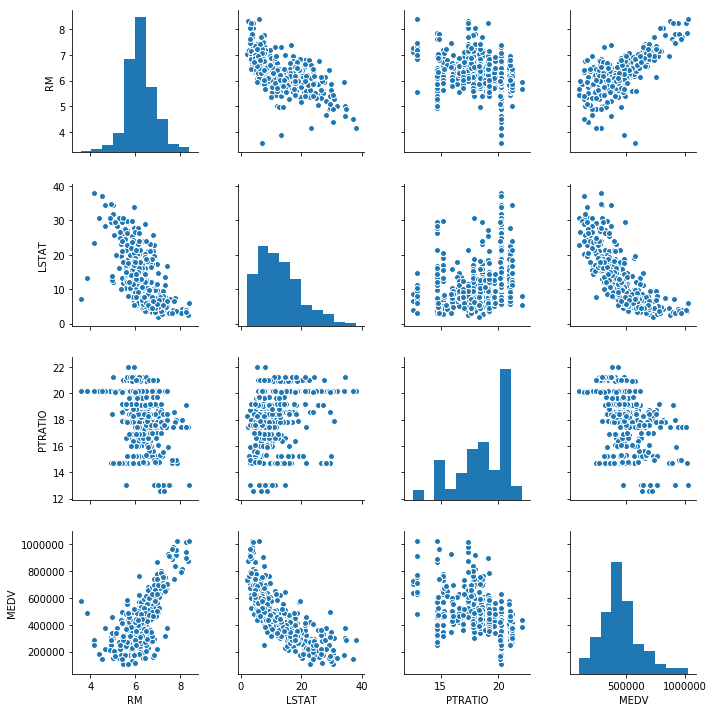

In [111]:
# A new dataframe with correlated variables

df = data[['RM', 'LSTAT', 'PTRATIO', 'MEDV']]
sns.pairplot(df, size=2.5)
plt.tight_layout()

From the pair plot we can see a linear relationship between ‘RM’ and House prices ‘MEDV’. In addition, we can infer from the histogram that the ‘MEDV’ variable seems to be normally distributed but contain several outliers.

**Analysis from the above data**

- Increase in **RM** increases the prices of the house i.e. **MEDV**
- Lower the value of LSTAT higher the value of MEDV
- PTRATIO decrease in the value increases MEDV

### Developing a Model

In this section, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model’s performance through the use of these tools and techniques helps to reinforce greatly the confidence in the predictions.

* Spliting the data

For this section we will take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [113]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state = 42)

Splitting a dataset into some ratio of training and testing subsets for a learning algorithm is useful to evaluate our model once it is trained. We want to know if it has learned properly from a training split of the data. There can be 3 different situations:

1) The model didn´t learn well on the data, and can’t predict even the outcomes of the training set, this is called underfitting and it is caused because a high bias.

2) The model learn too well the training data, up to the point that it memorized it and is not able to generalize on new data, this is called overfitting, it is caused because high variance.

3) The model just had the right balance between bias and variance, it learned well and is able predict correctly the outcomes on new data.

### Analyzing Model’s Performance

In this section we will observe at several models’ learning and testing performances on various subsets of training data.
Additionally, we’ll investigate one particular algorithm with an increasing 'max_depth' parameter on the full training set to observe how model complexity affects performance.

* Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased.

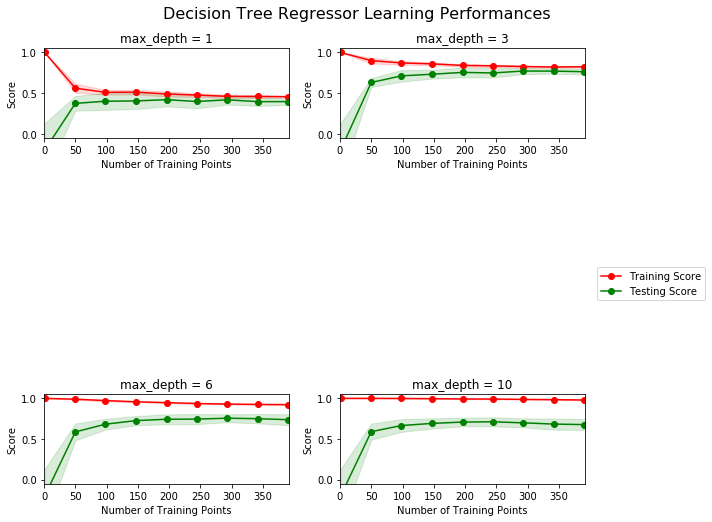

In [114]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

**Learning the Data**

If we take a close look at the graph with the max depth of 3:

* The score of the training curve decreases as more training points are added. This happens because with fewer training points, the model can modify its paramters to better approximate the targets; but as the number of training points increases, perfectly fitting them becomes more difficult, and the training score goes down.

* The score of the training curve increases as more training points are added, but there's a slight dip after adding more than 350 training points. The score starts lower because the model has not yet learned enough to predict test points. As the model receives more training points, and hence, more information, it is better suited to predict unseen data

* The training and testing curve seem to be converging to a score of 0.8. This usually happens when the model has stretched its limits of extracting information from the training data even though more training points are being added. So the score stabilizes.

* Therefore, having more training points might not benefit the model (with max_depth of 3).

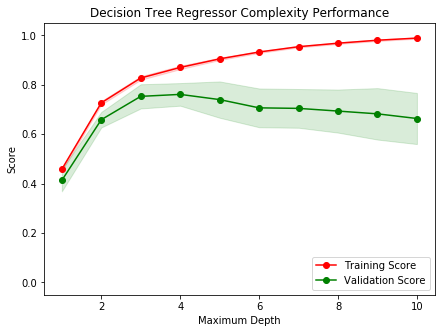

In [115]:
# Produce complexity curve for varying training set sizes and maximum depths
vs.ModelComplexity(X_train, y_train)

#### Bias-Variance Tradeoff

Here, we will analyse how the bias-variance vary with the maximun depth, we can infer that:

* With the max_depth=1, the above graph shows that the model does not return good score in neither training nor testing data, which is nothing but underfitting and so, high bias, low variance. To improve performance, we should increase model’s complexity, in this case increasing the max_depth hyperparameter to get better results.

- max_depth = 1, high bias --> low vairance --> Underfiiting --> Poor results

* With the max_depth=10, the graph shows that the model learns perfectly well from training data (with a score close to one) and also returns poor results on test data, which is an indicator of overfitting, not being able to generalize well on new data. This is a problem of High Variance. To improve performance, we should decrease the model’s complexity, in this case decreasing the max_depth hyperparameter to get better results.

- max_depth = 10, low bias --> high vairance --> Overfiiting --> better results

In my opinion, a maximum depth of 3 results in a model that best generalizes to unseen data. That depth is the sweet spot for model complexity, as our model performs similar on training and validation data, while the overall score for both is still relatively high at between 0.7 to 0.8. A depth lower than that gives us poor training and validation score, while a higher depth overfits on the testing data, leading to a lower validation score.


**Cross-Validation**

The k-fold crossvalidation training technique is a way of splitting the dataset into k partitions of equal size, and then running k separate learning experiments on the training data. In each of the experiments, we chose a training set of the size of k-1 partitions, train our model on that partition, and evaluate the results on the remaining test data. The results/scores for the k experiments are then averaged out.

This technique is benefitial when using grid search to optimize a model because it allows us to look for parameter settings that perform well for different test sets. If we had a single testing set, it's easy to tune a model to perform well for that specific test set (and result in overfitting on the test set in this case), while cross validation allows us to generalize the results.

### Fitting a Model

Now we'll bring everything together and train a model using the decision tree algorithm. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the 'max_depth' parameter for the decision tree. The 'max_depth' parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction.

In [116]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

In [117]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [118]:
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
data.head()

,Actual,Predicted
451,401100.0,342593.790298
84,501900.0,506257.091630
434,319200.0,410499.931662
472,147000.0,237792.741154
428,247800.0,327005.796532


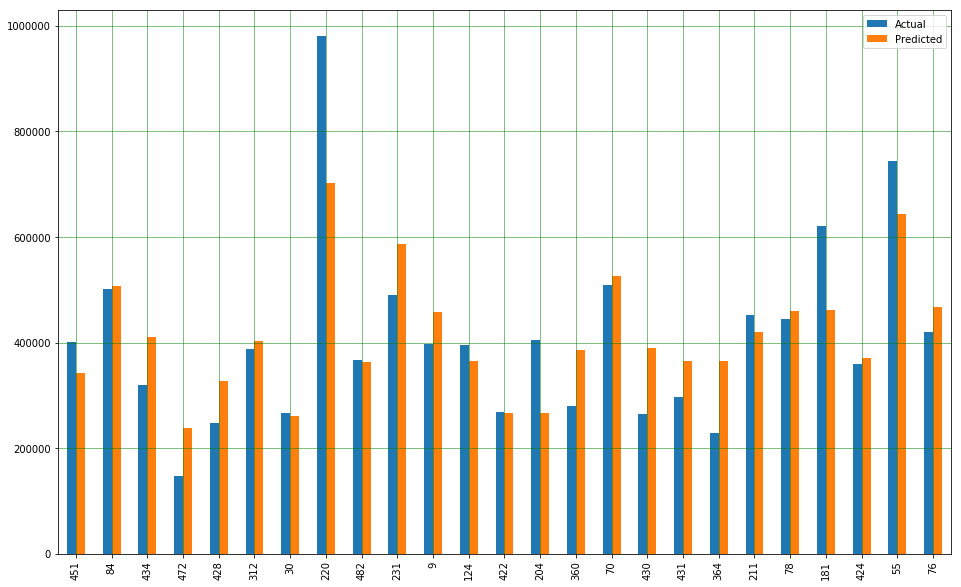

In [119]:
df1 = data.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [120]:
r2 = r2_score(y_test, y_pred)
print("r_square score", r2)

r_square score 0.6910934003098511


In [121]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

param_grid = [ {'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}, ]

In [122]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_true) and predicted (y_predict) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [123]:

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [124]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


### Making Predictions

Once a model has been trained on a given set of data, it can be used to make predictions on new sets of input data. In the case of a decision tree regressor, the model has learned what the best questions to ask about the input data are, and can respond with a prediction for the **target variable.**

In [125]:
r2 = r2_score(y_test, y_pred)
print("r_square score", r2)

r_square score 0.6910934003098511


**Answer**: The optimal model has a max depth of 4, which is close enough to the previous guess of 3 earlier. Going back to the complexity graph, the model might perform better on the test set with a max depth of 4, but since the difference is minimal (which can also be due to noise), it might make sense to chose the simpler model.


### Predicting Selling Prices

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

Let's see what prices our model will predict for these clients, and if they seem reasonable given the features.

|Feature |Client 1   |Client 2   |Client 3  |
|---|---|---|---|
| Total number of rooms in home  | 5 rooms  |  4 rooms |  8 rooms |
| Neighborhood poverty level (as %)  | 17%  | 32%  | 3%  |
| Student-teacher ratio of nearby schools  | 15-to-1  |22-to-1   | 12-to-1  |

In [126]:

# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print ("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


The prices seem reasonable given the features of the homes. We can see that the highest priced home has the most rooms, lowest neighbourhood poverty level, and the lowest student-teacher ratio, all of which make intuitive sense as discussed in the Question 1. On the contrary, the home with the lowest number of rooms, highest neighbourhood poverty level, and highest student-teacher ratio is priced the lowest in our predictions.

This finishes our project. We have built a decision tree regressor that performs reasonably well given the 3 features. But should the model should be used in a real-world setting? It probably shouldn't because:

* The data collected in 1978 is not really relevant today due to rising population levels and changing population density of different areas.
* The features present in the data that we built our model on are not likely be sufficient to describe a home. Examples of interesting features to look at may be proximity to city center, or neighbourhood crime rate.
* The data collected in an urban city will not be applicable in a rural city, because the people might value different aspects of a home depending on whether they live in an urban city or a rural area. For example, a person living in a rural city might value number of rooms in a home over the proximity to the city.